In [1]:
import pandas as pd
import string
import nltk
import spacy
import re
import torch.nn.functional as F
import seaborn as sns
from keras.utils import pad_sequences
from sklearn import preprocessing
from torch import nn
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /Users/gke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/gke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('data/Tweets.csv')
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.groupby('airline_sentiment')['text'].nunique()

airline_sentiment
negative    9087
neutral     3067
positive    2298
Name: text, dtype: int64

### Check Balance

In [4]:
df_iter = df.groupby('airline_sentiment')['text'].nunique().sort_values(ascending=False).reset_index(drop=True)
group = []
values = []
for k,v in df_iter.items():
    group.append(k)
    values.append(v)
df_nunique = pd.DataFrame({'group' : group , 'values':values})

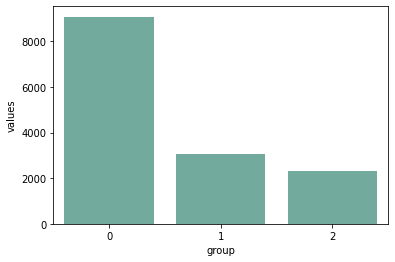

In [5]:
sns.barplot(
    x="group", 
    y="values", 
    data=df_nunique, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);

### Cleaning

In [12]:
lemmatizer = WordNetLemmatizer()

# since these are tweets, remove the @s to the airline and other users
def remove_statics(text):
    text = re.sub('@([A-Za-z0-9a_]+)', '' , text)
    return text

def remove_punctuations(text):
    text = str(text)
    return text.translate(str.maketrans('' , '' , string.punctuation)).lower()

def remove_non_alnum(text):
    text = str(text)
    text_list = [ch for ch in text.split() if ch.isalnum()]
    return ' '.join(text_list)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = text.split()
    return ' '.join([e for e in text if e not in stop_words])

def lemmatize(text):
    lemmatized_text = []
    for word in text.split():
        lemmatized_text.append(lemmatizer.lemmatize(word))
    return ' '.join(lemmatized_text)

def pos_tag(tokenized_text):
    tokenized_text = tokenized_text.split()
    return nltk.pos_tag(tokenized_text)

def tokenize_text(inputString):
    if type(inputString) is pd.Series:
        df_u = pd.DataFrame(inputString)
    else:
        df_u = pd.DataFrame([{'preprocessed_text':inputString}])
    max_features = 5000
    oov = 'OOV'
    tokenizer = Tokenizer(num_words = max_features , oov_token = oov)
    tokenizer.fit_on_texts(df_u['preprocessed_text'])
    tokenized = tokenizer.texts_to_sequences(df_u['preprocessed_text'])
    return tokenized , tokenizer

In [13]:
df['preprocessed_text'] = df['text'].apply(remove_stopwords)
df['preprocessed_text'] = df['text'].apply(remove_statics)
df['preprocessed_text'] = df['preprocessed_text'].apply(lemmatize)
df['preprocessed_text'] = df['preprocessed_text'].apply((remove_punctuations))
df['preprocessed_text'] = df['preprocessed_text'].apply(remove_non_alnum)
df['text_pos'] = df['text'].apply(pos_tag)
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,preprocessed_text,text_pos
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said,"[(@VirginAmerica, VB), (What, WP), (@dhepburn,..."
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus youve added commercial to the experience ...,"[(@VirginAmerica, JJ), (plus, CC), (you've, NN..."
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didnt today must mean i need to take another...,"[(@VirginAmerica, NN), (I, PRP), (didn't, VBP)..."
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),its really aggressive to blast obnoxious enter...,"[(@VirginAmerica, NN), (it's, NN), (really, RB..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and its a really big bad thing about it,"[(@VirginAmerica, NN), (and, CC), (it's, VB), ..."


In [17]:
labels = df['airline_sentiment'].unique()
le = preprocessing.LabelEncoder()
encoded_labels = le.fit(labels)
article_category_le = le.transform(df['airline_sentiment'])
print(encoded_labels.classes_)

['negative' 'neutral' 'positive']


In [15]:
tokenized_x , tokenizer = tokenize_text(df['preprocessed_text'].astype(str))

In [18]:
len(le.classes_)

3

### Splits

In [19]:
from sklearn.model_selection import train_test_split
MAX_LEN = 5000
Xtrain = pad_sequences(tokenized_x , maxlen=MAX_LEN)
X_train , X_test , y_train , y_test = train_test_split(Xtrain , article_category_le , test_size = 0.20 , random_state = 13)

In [22]:
X_test.shape

(2928, 5000)

In [ ]:
y_test.shape

In [24]:
import tensorflow as tf

### Model

In [33]:
sequence_length = X_train.shape[1]
vocab_size = 5000
filter_sizes = [3 , 4 , 5]
num_filters = 128
drop = 0.50
epochs = 5
embed_dim = 64

num_of_classes = len(le.classes_)
input = tf.keras.layers.Input(shape = (sequence_length ,))
embedding = tf.keras.layers.Embedding(sequence_length, embed_dim)(input)
conv1 = tf.keras.layers.Conv1D(num_filters , kernel_size = (filter_sizes[0]) , padding='valid',activation='relu')(embedding)
flatten = tf.keras.layers.Flatten()(conv1)
output = tf.keras.layers.Dense(num_of_classes)(flatten)

model = tf.keras.models.Model(input , output)
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5000)]            0         
                                                                 
 embedding_4 (Embedding)     (None, 5000, 64)          320000    
                                                                 
 conv1d_7 (Conv1D)           (None, 4998, 128)         24704     
                                                                 
 flatten_3 (Flatten)         (None, 639744)            0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1919235   
                                                                 
Total params: 2,263,939
Trainable params: 2,263,939
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
model.compile(optimizer='adam' , loss = 'sparse_categorical_crossentropy' , metrics=['accuracy'])

In [35]:
model.fit(X_train , y_train , batch_size=64 , epochs = 5, verbose=1 , validation_data=(X_test , y_test))

Epoch 1/5


2022-09-05 21:12:37.336256: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


183/183 [==============================] - 52s 281ms/step - loss: 1.1460 - accuracy: 0.6218 - val_loss: 1.0986 - val_accuracy: 0.6349
Epoch 2/5
183/183 [==============================] - 56s 306ms/step - loss: 1.0986 - accuracy: 0.6249 - val_loss: 1.0986 - val_accuracy: 0.6349
Epoch 3/5
183/183 [==============================] - 59s 324ms/step - loss: 1.0986 - accuracy: 0.6249 - val_loss: 1.0986 - val_accuracy: 0.6349
Epoch 4/5
183/183 [==============================] - 60s 330ms/step - loss: 1.0986 - accuracy: 0.6249 - val_loss: 1.0986 - val_accuracy: 0.6349
Epoch 5/5
183/183 [==============================] - 66s 359ms/step - loss: 1.0986 - accuracy: 0.6249 - val_loss: 1.0986 - val_accuracy: 0.6349
